#### 1) 데이터 불러오기

In [ ]:
import os
import cv2
import numpy as np
import random
import torch

# 시드(seed) 고정
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/SharedDrive/Colab Notebooks/딥러닝과 응용/SourceCode_01_GD_ANN/Datasets
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝과 응용/SourceCode_01_GD_ANN/Datasets

/content/drive/.shortcut-targets-by-id/1mHTLf21YfzdDibqqXZ1lu9bkkHQt3uFy/Colab Notebooks/딥러닝과 응용/SourceCode_01_GD_ANN/Datasets


In [ ]:
# 하이퍼 파라미터 설정
class Parameters():
    def __init__(self):
        self.description = 'ResNet for Image Classification'

        # 에포크 수
        self.epochs = 50
        # 배치 크기
        self.batch_size = 16
        # 학습률
        self.learning_rate = 1e-4 # 0.0001
        # 훈련된 모델 경로
        self.model_name = 'ResNet'
        # 파일명
        self.data_path = './Datasets/SEM'
args = Parameters()

In [ ]:

def load_dataset(groups_folder_path, categories):

    Y = []
    X = []

    for idx, category in enumerate(categories):
        label = idx  # 정수 레이블로 변경
        image_dir = os.path.join(groups_folder_path, category)

        file_list = os.listdir(image_dir)

        for filename in file_list:
            if filename.lower().endswith('.jpg'):
                url = os.path.join(image_dir, filename)
                img = cv2.imread(url)
                if img is not None:  # 이미지를 성공적으로 읽었는지 확인
                    X.append(img)
                    Y.append(label)

    return X, Y

train_folder_path = os.path.join(args.data_path, 'Train')
test_folder_path = os.path.join(args.data_path, 'Test')
categories = ['SPOT', 'LSAC', 'RING']

X, Y = load_dataset(train_folder_path, categories)
x_test, y_test = load_dataset(test_folder_path, categories)

In [ ]:
X = np.array(X)
Y = np.array(Y)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"훈련 이미지 데이터 shape: {X.shape}")
print(f"훈련 레이블 데이터 shape: {Y.shape}")
print(np.unique(Y, return_counts=True))

print(f"\n테스트 이미지 데이터 shape: {x_test.shape}")
print(f"테스트 레이블 데이터 shape: {y_test.shape}")
print(np.unique(y_test, return_counts=True))

훈련 이미지 데이터 shape: (803, 224, 224, 3)
훈련 레이블 데이터 shape: (803,)
(array([0, 1, 2]), array([268, 267, 268]))

테스트 이미지 데이터 shape: (303, 224, 224, 3)
테스트 레이블 데이터 shape: (303,)
(array([0, 1, 2]), array([101, 101, 101]))


In [ ]:
from sklearn.model_selection import train_test_split
# 훈련 및 테스트 데이터 추출
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (642, 224, 224, 3)
y_train shape: (642,)
x_valid shape: (161, 224, 224, 3)
y_valid shape: (161,)
x_test shape: (303, 224, 224, 3)
y_test shape: (303,)


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 데이터 증강 정의 (학습 데이터셋에만 적용)

# transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))

# 증강 확률의 기본값은 0.5
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(), # 상하 반전
    transforms.RandomHorizontalFlip(), # 좌우 반전
    transforms.RandomRotation(90), #  (-degree, +degree) 사이만큼 회전
    transforms.RandomGrayscale(), # 흑백화
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
   # transforms.RandomErasing(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet 데이터셋에 사용된 평균과 표준편차 사용
])

# 검증 및 테스트 데이터셋에는 증강 적용 안 함
test_transform = transforms.Compose([
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet 데이터셋에 사용된 평균과 표준편차 사용
])

class CustomDataset(Dataset):
    def __init__(self, X, y, mode='train'):  # mode 인자 추가
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.mode = mode  # mode 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.mode == 'train':
            x = train_transform(x)
        else:  # 'valid' 또는 'test'
            x = test_transform(x)
        y = self.y[idx]
        return x, y

# Dataset 생성
train_dataset = CustomDataset(x_train, y_train, mode='train')
valid_dataset = CustomDataset(x_valid, y_valid, mode='valid')
test_dataset = CustomDataset(x_test, y_test, mode='test')
# DataLoader 정의

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True) # 학습 로더에서 나오는 데이터는 항상 섞어줍니다
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False) # 평가를 위해서 순차적으로 나오게 합니다
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False) # 평가를 위해서 순차적으로 나오게 합니다

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

#### 2) Transfer Learning

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/cifar10.png)

* pretrain weight 사용
* 이미지넷 데이터셋은 1,000개의 클래스로 구성되며 총 백만 개가 넘는 데이터를 포함
* 학습 데이터셋 용량은 약 138GB, 검증 데이터셋 용량은 약 6GB

#### 3) 모델 불러오기 (Resnet18)
- fine tuning
   - 사전 훈련된 가중치를 재학습
   - 사전 훈련된 가중치를 학습하지 않고 마지막 classifer만 학습
   - 사전 훈련된 가중치를 특정 레이어 이후만 학습

In [ ]:
import torchvision.models as models # torchvision에서 제공하는 model zoo를 활용

"""
torchvision model zoo에서 제공하는 pretrained 가중치를 불러오는 인자 옵션에는 2가지가 있음
(More information provided in https://pytorch.org/vision/stable/models.html)

1) 기존 방식 -> pretrained = True로 지정하여 pretrained weight을 load하는 방법, False로 지정 시 random initialization (v0.15부터는 지원 중단)
2) 현재 방식 -> weights 인자에 지정하는 방식으로, boolean type의 인자가 아니라 weights에 모델 버전을 상수 혹은 string 형태로 지정하는 방식임. None을 지정 시 random init

"""


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

for param in model.parameters():
    param.requires_grad = True

# # layer4 이후로만 학습가능하게 할 수 있음
# for name, _ in model.named_parameters():
#    # print(name)
#     if name.startswith('layer4'):  # layer4부터 학습 가능
#         param.requires_grad = True

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
# 분류할 클래스 수로 변경
model.fc = nn.Linear(512, 3).to(device)

#### 3) 학습

In [ ]:
import torch


def train(model, train_loader, optimizer, criterion, device):

    # 모델을 학습 모드로 설정
    model.train()
    # loss 누적값 초기화
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader: # 로더에서 배치 사이즈만큼 데이터와 레이블 랜덤 추출
        inputs, labels = inputs.to(device), labels.to(device) # device로 옮기기

        # 기울기 초기화
        optimizer.zero_grad()

        outputs = model(inputs) # 모델에 인풋데이터 입력하여 아웃풋 추출

        loss = criterion(outputs, labels) # 아웃풋과 레이블과의 loss 계산

        loss.backward() # 파라미터에 대한 loss 기울기 계산
        optimizer.step() # 파라미터 업데이트

        # loss 누적
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = correct_preds / len(train_loader.dataset)

    return avg_loss, accuracy

# 평가 함수 정의
def evaluate(model, loader, criterion, device):
    # 모델을 평가 모드로 설정
    model.eval()
    running_loss = 0.0

    # 정확하게 예측된 샘플 수를 초기화
    correct_preds = 0
    # 모든 예측과 실제 레이블을 저장할 리스트를 초기화
    all_preds = []
    all_labels = []

    # 기울기를 계산하지 않도록 torch.no_grad() 내에서 연산 수행
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # 예측된 클래스를 가져와 정확하게 예측된 샘플 수를 누적
            _, predicted = torch.max(outputs, 1)
            correct_preds += torch.sum(predicted == labels).item()

            # 예측 결과와 실제 레이블을 리스트에 추가
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 전체 데이터셋에 대한 평균 손실을 계산
    avg_loss = running_loss / len(loader.dataset)
    # 정확도를 계산
    accuracy = correct_preds / len(loader.dataset)
    # 평균 손실, 정확도, 예측된 값들, 실제 레이블들을 반환
    return avg_loss, accuracy, all_preds, all_labels

In [ ]:
class EarlyStopping:
    """
    조기 종료(Early Stopping) 클래스: 특정 에폭 동안 손실(loss)이 개선되지 않으면 훈련 중단
    """

    def __init__(self, patience=3, min_delta=0):
        """
        초기화 함수: patience, min_delta 값을 설정하고 카운터, best_loss를 초기화

        min_delta (float): 새로운 손실이 이전 손실보다 개선되었다고 간주하기 위한 최소 차이
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        """
         검증 손실(val_loss)을 받아 조기 종료 여부를 결정

        Returns:
            bool: 조기 종료해야 하는 경우 True, 계속 훈련해야 하는 경우 False
        """
        if self.best_loss is None:  # 첫 번째 에폭인 경우 best_loss 설정
            self.best_loss = val_loss

        elif self.best_loss - val_loss > self.min_delta:  # 손실이 충분히 개선된 경우
            self.best_loss = val_loss
            self.counter = 0  # 카운터 초기화

        else:  # 손실이 개선되지 않은 경우
            self.counter += 1

            if self.counter >= self.patience:  # patience 만큼 손실이 개선되지 않으면
                print("[INFO] Early stopping")  # 조기 종료 메시지 출력
                return True  # 조기 종료 신호 반환

        return False  # 계속 훈련 신호 반환

In [ ]:
import torch

class LRScheduler():
    """
    학습률 스케줄러. 주어진 `patience` 에포크 동안 검증 손실이 감소하지 않으면
    학습률을 주어진 `factor`만큼 감소.
    """
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5, verbose=True):
        """
        new_lr = old_lr * factor
        :param optimizer: 사용할 옵티마이저
        :param patience: 학습률을 업데이트하기 전에 기다릴 에포크 수
        :param min_lr: 학습률이 감소할 수 있는 최소 값
        :param factor: 학습률을 감소시킬 비율
        :param verbose: 학습률이 조정될 때 메시지를 출력할지 여부
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.verbose = verbose

        # ReduceLROnPlateau 스케줄러 사용
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=self.verbose
        )

    def __call__(self, val_loss):
        """
        검증 손실을 기준으로 학습률을 조정합니다.
        :param val_loss: 현재 검증 손실 값
        """
        self.lr_scheduler.step(val_loss)

In [ ]:
# from utils.EarlyStopping      import *
# from utils.LRScheduler        import *
# from utils.train_eval_util import train, evaluate


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr     = args.learning_rate)


early_stopping = EarlyStopping(patience  = 7,
                               min_delta = 1e-5)


scheduler = LRScheduler(optimizer = optimizer,
                        patience  = 5,
                        min_lr    = 1e-10,
                        factor    = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
best_valid_loss = float('inf')

# 학습률 스케줄러 정의
train_losses = []
valid_losses = []

for epoch in range(args.epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch [{epoch+1}/{args.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + args.model_name + ".pth")

Epoch [1/50], Train Loss: 0.5130, Train Acc: 0.8084, Valid Loss: 0.2530, Valid Acc: 0.9193
Epoch [2/50], Train Loss: 0.2926, Train Acc: 0.8910, Valid Loss: 0.2521, Valid Acc: 0.8696
Epoch [3/50], Train Loss: 0.2603, Train Acc: 0.9050, Valid Loss: 0.1817, Valid Acc: 0.9255
Epoch [4/50], Train Loss: 0.2615, Train Acc: 0.9019, Valid Loss: 0.3182, Valid Acc: 0.8634
Epoch [5/50], Train Loss: 0.2320, Train Acc: 0.9159, Valid Loss: 0.2138, Valid Acc: 0.9006
Epoch [6/50], Train Loss: 0.2573, Train Acc: 0.8941, Valid Loss: 0.1297, Valid Acc: 0.9441
Epoch [7/50], Train Loss: 0.1871, Train Acc: 0.9252, Valid Loss: 0.2210, Valid Acc: 0.9193
Epoch [8/50], Train Loss: 0.2320, Train Acc: 0.9097, Valid Loss: 0.1463, Valid Acc: 0.9317
Epoch [9/50], Train Loss: 0.1800, Train Acc: 0.9190, Valid Loss: 0.1733, Valid Acc: 0.9255
Epoch [10/50], Train Loss: 0.1889, Train Acc: 0.9252, Valid Loss: 0.1468, Valid Acc: 0.9379
Epoch [11/50], Train Loss: 0.1911, Train Acc: 0.9361, Valid Loss: 0.1523, Valid Acc: 0.92

In [ ]:
# 저장된 모델 로드
import torchvision.models as models


model = models.resnet18().to(device)
model.fc = nn.Linear(512, 3).to(device)
model.load_state_dict( torch.load( "./" + args.model_name + ".pth" ) )

# 테스트 세트 평가
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

<ipython-input-184-76b788a65239>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( "./" + args.model_name + ".pth" ) )


Test Loss: 0.2371, Test Acc: 0.9241


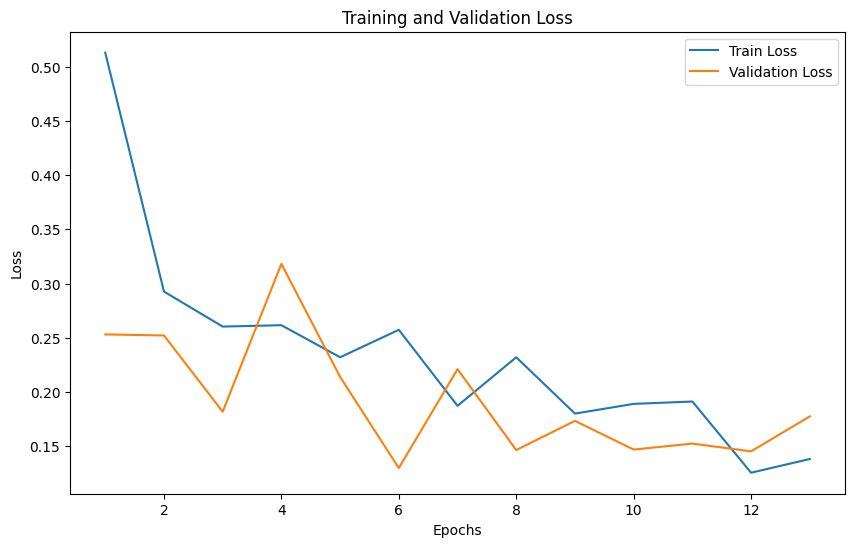

In [ ]:
import matplotlib.pyplot as plt

# Train vs Validation Loss 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

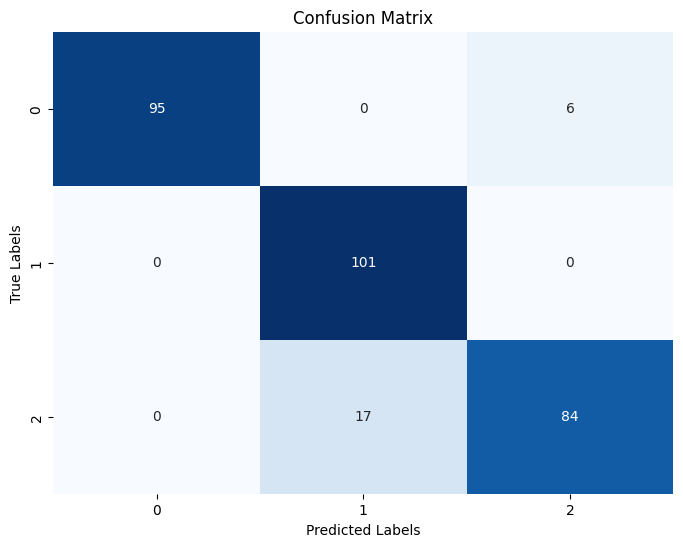

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
conf_matrix = confusion_matrix(test_labels, test_preds)
# Confusion Matrix 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Grad-CAM 설치
# !pip install grad-cam

In [ ]:
import math
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def apply_gradcam(model, images, targets, cam_algorithm):
    # GradCAM을 적용하여 CAM을 얻는 함수
    grayscale_cams = cam_algorithm(input_tensor=images, targets=targets)
    return grayscale_cams

# DataLoader에서 이미지와 레이블을 추출
images_list = []
labels_list = []
predictions_list = []

for i, (images, labels) in enumerate(test_loader):
    images_list.append(images)
    labels_list.append(labels)

    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predictions_list.append(predicted)

# 모델을 평가 모드로 설정
model.eval()
target_layers = [model.layer4[-1]]
cam = EigenCAM(model=model, target_layers=target_layers)

# 리스트 평탄화
images_list = torch.cat(images_list)
labels_list = torch.cat(labels_list)
predictions_list = torch.cat(predictions_list)

# 표시할 이미지 수
num_images = 10 # 전체는 images_list.size(0)
num_cols = 5
num_rows = math.ceil(num_images / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6))
axes = axes.flatten()

# 미리 추출한 이미지, 레이블, 예측을 반복합니다.
for idx in range(num_images):
    images = images_list[idx].unsqueeze(0)
    labels = labels_list[idx]
    predicted = predictions_list[idx]

    # 현재 이미지의 예측 레이블 입력
    targets = [ClassifierOutputTarget(predicted.item())]

    # GradCAM을 적용
    grayscale_cam = apply_gradcam(model, images, targets, cam)
    grayscale_cam = grayscale_cam[0, :]  # 배치 차원 제거

    # 이미지를 원래 형태로 변환
    image_denormalized = images_list[idx] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    rgb_img = image_denormalized.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # 결과 시각화
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)

    ax = axes[idx]
    ax.imshow(visualization)
    true_label_name = categories[labels.item()]
    predicted_label_name = categories[predicted.item()]
    ax.set_title(f"True: {true_label_name} Pred: {predicted_label_name}", fontsize=20)
    ax.axis('off')

for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'pytorch_grad_cam'